In [1]:
using Plots
pyplot() # plots backend

Plots.PyPlotBackend()

In [2]:
x_min = 0
x_max = 2*pi

N = 8

x = reshape(Array(linspace(x_min, x_max, N)), (N,1));
# x = x_min + (rand(10,1) * x_max);
y = sin.(x);

N_test = 50
x_test = reshape(Array(linspace(x_min, x_max, N_test)), (N_test,1));

In [3]:
size(x), size(x_test), size(X), size(X_test)

LoadError: [91mUndefVarError: X not defined[39m

### Linear regression : $y = Xw$


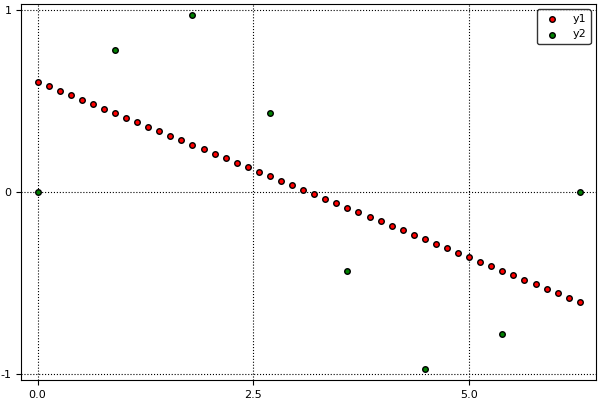

In [4]:
X = hcat(x, ones(size(x)[1])) # add bias term
w = inv(X'*X)*X' * y

X_test = hcat(x_test, ones(size(x_test)[1]))
y_hat = X_test*w
plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")

### Linear regression on non-linear mapping: $y = \phi(X)w$

Notice how adding non-linear features helps model fit much better


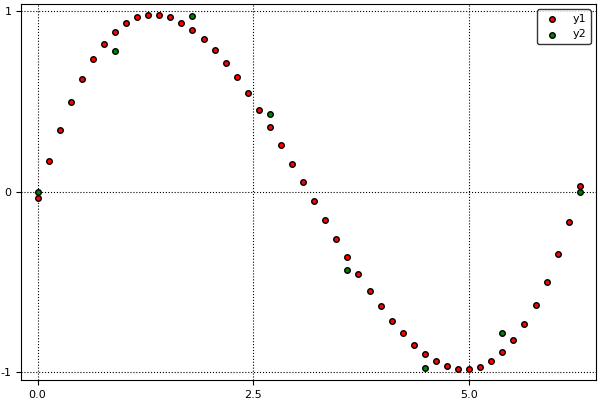

In [5]:
function phi(x)
    return [x x.^2 x.^3 ones(size(x)[1])]
end

X = phi(x)
w = inv(X'*X)*X' * y

X_test = phi(x_test)
y_hat = X_test*w
plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")

### Bayesian linear regression


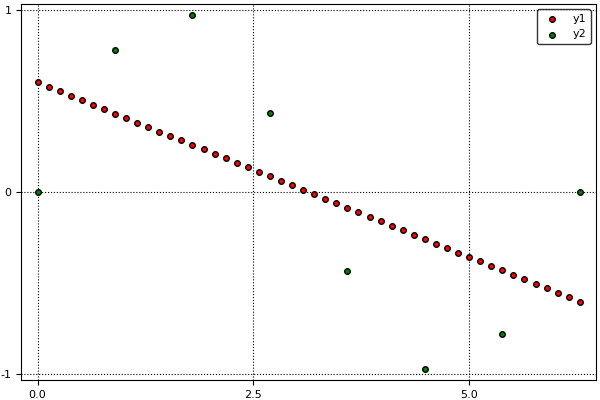

In [6]:
# Mess with these parameters to see effects
sigma_n = 0.1 # Assumed noise on y
Sigma_p = eye(2) # covariance matrix on prior

X = hcat(x,ones(size(x)[1])) # add bias term
A = (X'*X)+sigma_n^2 * inv(Sigma_p)
mu_w = inv(A)*X'*y
sigma_w = sigma_n^2*inv(A)

X_test = hcat(x_test, ones(size(x_test)[1]))
y_hat = X_test*mu_w
plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")

### Bayesian linear regression with nonlinear mapping


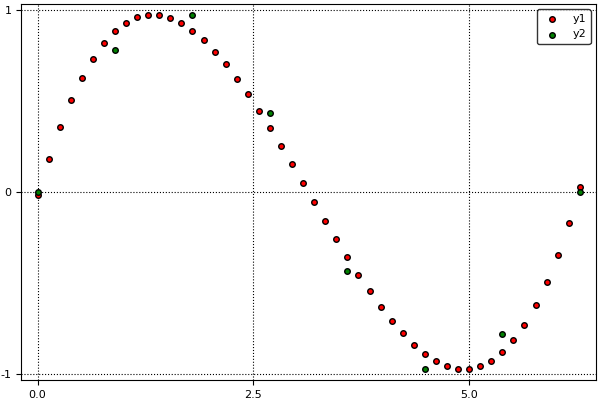

In [7]:
sigma_n = 0.1 # Assumed noise on y
Sigma_p = eye(4) # covariance matrix on prior

X = phi(x)
A = (X'*X)+sigma_n^2 * inv(Sigma_p)
mu_w = inv(A)*X'*y
sigma_w = sigma_n^2*inv(A)

A_batch = A;
b_batch = X'*y;

X_test = phi(x_test)
y_hat = X_test*mu_w
plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")

### Incremental bayesian linear regression with non-linear mapping: updating $A$ matrix

In [8]:
n_params = 4 # dimensionality of phi
sigma_n = 0.1 # Assumed noise on y
Sigma_p = eye(n_params) # covariance matrix on prior

# Initialize 
A_inc = sigma_n^2 * inv(Sigma_p)
b_inc = zeros(4)

for i = 1:size(x)[1]
    phi_t = phi(x[i,:])'
    y_t = y[i]
    A_inc = A_inc + phi_t*phi_t'
    b_inc = b_inc + phi_t*y_t
end

# We can get the same results incrementally!
print("Compared to matrices from batch learning: ", norm(A_inc-A_batch), " ", norm(b_inc-b_batch))

Compared to matrices from batch learning: 1.4551915228366852e-11 2.929673353772522e-14


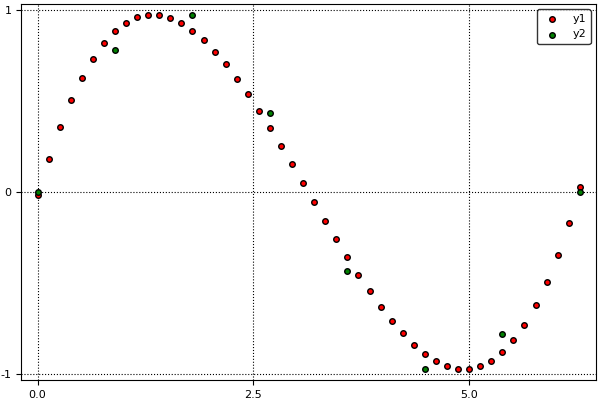

In [9]:
X = phi(x)
mu_w = inv(A_inc)*X'*y

X_test = phi(x_test)
y_hat = X_test*mu_w
plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")

### Incremental bayesian linear regression with non-linear mapping: updating $R$ (cholesky factor of $A$)

The incremental BLR method that updates the $A$ matrix directly (shown above) still rerquires computation of $A^{-1}$ every time we want a prediction. This is $O(n^3)$. To avoid this, we can instead update the Cholesky factor of $A = R^T R$, which we can use to "multiply by the inverse" with forward and backsubstitution, in $O(n^2)$.

In [10]:
n_params = 4 # dimensionality of phi
sigma_n = 0.1 # Assumed noise on y
Sigma_p = eye(n_params) # covariance matrix on prior

# Initialize 
R = sigma_n * eye(n_params)
b = 0

for i = 1:size(x)[1]
    phi_t = phi(x[i,:])'
    y_t = y[i]
    
    b = b + phi_t*y_t
    
    R_temp = vcat(R, phi_t')
    _,R = qr(R_temp)
end

# We can get the same results incrementally!
print("Difference compared to batch learning: ", norm(R'*R - A_batch), norm(b - b_batch))

Difference compared to batch learning: 4.551927436812486e-132.929673353772522e-14


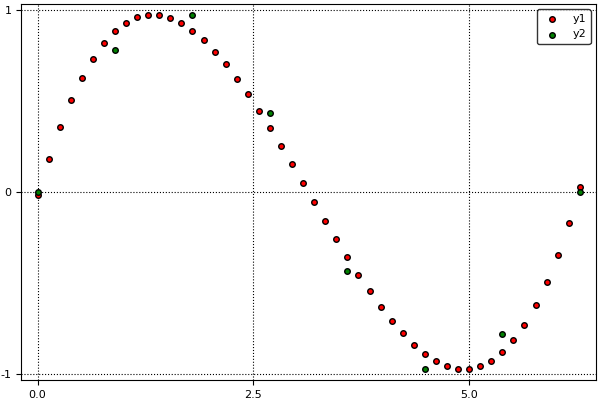

In [11]:
X = phi(x)
mu_w = inv(R'*R)*X'*y # This makes the cholesky totally useless; in practice we use triangular structure to solve efficiently

X_test = phi(x_test)
y_hat = X_test*mu_w
plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")

### Kernel method

In [12]:
""" 
GP squared exponential kernel 
currently assumes vector input of shape [n x D], where n is number of points, D is dimensionality of each input
compute kernel matrix one element at a time - not the most efficient...
"""
function se_kernel(a, b)
    lengthscale = 0.5 # horizontal scale
    sigma = 1 # vertical variation
    K = zeros(size(a)[1], size(b)[1])
    for i = 1:size(a)[1]
        for j = 1:size(b)[1]
            sq_diff = sum((a[i,:]-b[j,:]).^2)
            K[i,j] = sigma^2 * exp.(-0.5/lengthscale * sq_diff)
        end
    end    
    return K
#     sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
#     return sigma**2 * np.exp(-0.5 * (1/kernelParameter) * sqdist)
end

se_kernel

In [13]:
# x: test points, X: train points
K_xx = se_kernel(x_test, x_test)
K_xX = se_kernel(x_test, x) 
s = 1e-2    # noise variance.
K_XX = se_kernel(x,x) + s*eye(size(x)[1])
mu = K_xX * inv(K_XX) * y; # typically done with cholesky factor
cov = K_xx - (K_xX * inv(K_XX) * K_xX');
stds = diag(cov); 


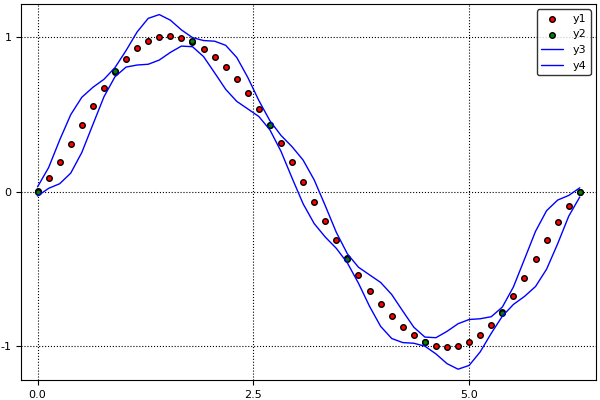

In [14]:
plot()
scatter!(x_test, mu, color="red")
scatter!(x, y, color="green")
plot!(x_test, mu + 3*stds, color="blue")
plot!(x_test, mu - 3*stds, color="blue")
# plot!(x_test, mu)

### Sparse spectrum Gaussian process regression

Approximate infinite-dimensional kernel with something like "randomized Fourier transform".

TODO 
* quantitative comparison to normal GP with squared-exponential kernel (done in Limbo)
* plot uncertainty for bayesian LR and GPs

In [22]:
dim_x = 1
D = 10 # number of random vectors to project on

sigma_f = 1 # hyperparameter of squared-exponential kernel
lengthscale = 0.25

# construct features first
w_all = randn((D, dim_x))

# Projection of x onto random feature mapping for SE kernel
function phi_rand(x)
    # curently accepts only 1 vector (i.e. can't broadcast)
    return (sigma_f/sqrt(D)) * [sin.(w_all*x)/lengthscale; cos.(w_all*x)/lengthscale]
end

phi_rand (generic function with 1 method)

In [58]:
function pretty_print(name, A)
    println(name, ":");
    show(STDOUT, "text/plain", A);
    print("\n")
end

pretty_print (generic function with 1 method)

In [62]:
# Incremental updates

# Initialize 
R = sigma_n * eye(2*D)
b = 0

for i = 1:size(x)[1]
    phi_t = phi_rand(x[i,:]) 
    y_t = y[i]
    b = b + phi_t*y_t
    
#     print("phi: ", phi_t, '\n')
#     pretty_print("R", R)
    R_temp = vcat(R, reshape(phi_t, (1, 2*D)))
    _,R = qr(R_temp)
#     pretty_print("R_temp", R_temp)
#     pretty_print("R", R)
#     println("---")
end

phi: [0.556322, -0.55574, 0.337391, 0.154401, -0.156481, -0.468509]
R:
6×6 Array{Float64,2}:
 0.1  0.0  0.0  0.0  0.0  0.0
 0.0  0.1  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.0
 0.0  0.0  0.0  0.0  0.0  0.1
R_temp:
7×6 Array{Float64,2}:
 0.1        0.0      0.0       0.0        0.0        0.0     
 0.0        0.1      0.0       0.0        0.0        0.0     
 0.0        0.0      0.1       0.0        0.0        0.0     
 0.0        0.0      0.0       0.1        0.0        0.0     
 0.0        0.0      0.0       0.0        0.1        0.0     
 0.0        0.0      0.0       0.0        0.0        0.1     
 0.556322  -0.55574  0.337391  0.154401  -0.156481  -0.468509
R:
6×6 Array{Float64,2}:
 -0.565238   0.546974  -0.332069   -0.151965    0.154013     0.461118  
  0.0       -0.140238   0.0418482   0.0191511  -0.0194091   -0.0581113 
  0.0        0.0       -0.108681   -0.0076284   0.00773117   0.0231473 
  0.0        0.0      

In [63]:
# Make predictions given R and b 

# Construct random feature mappings for training and test sets
Phi_X = zeros(size(x)[1], 2*D)
for i = 1:size(x)[1]
    Phi_X[i,:] = phi_rand(x[i,:])
end

Phi_X_test = zeros(size(x_test)[1], 2*D)
for i = 1:size(x_test)[1]
    Phi_X_test[i,:] = phi_rand(x_test[i,:])
end

mu_w = inv(R'*R)*Phi_X'*y
y_hat = Phi_X_test*mu_w

sigma_n = 0.2
cov = sigma_n^2 * (1 + Phi_X_test * inv(R'*R) * Phi_X_test')
stds = diag(cov)

plot()
scatter!(x_test, y_hat, color="red")
scatter!(x, y, color="green")
plot!(x_test, y_hat + 3*stds, color="blue")
plot!(x_test, y_hat - 3*stds, color="blue")

LoadError: [91mDimensionMismatch("Cannot multiply two vectors")[39m

### Givens rotations

**TODO** use this for qr update in incremental step. Can't figure out how to zero out an entire row (specifically, the last element), since zeoing one element in a row affects the whole row. 

Now on to incrementally updating the Cholesky factor instead (to avoid inverse), which uses Givens rotations!

In [274]:
"""
Givens rotations
Naive (numerically unstable) implementation from https://en.wikipedia.org/wiki/Givens_rotation

 a, b : values of matrix at locations to be rotated (b to be zeroed)
 i, j : rows to be rotated (j to be zeroed)
 n: size of matrix (assume square)

TODO clean up interface, implement better version
"""
function givens_rotation_mat(A,pos,rotate_up=1) # (a,b,i,j,n)
    n = size(A)[1]
    
    if rotate_up==1
        i = pos[1]-1 # assume we're rotating up one row
    else
        i = pos[1]+1 # 
    end
        
    j = pos[1]
    a = A[i, pos[2]] 
    b = A[j, pos[2]]
    
    M = eye(n)
    r = sqrt(a^2 + b^2) # epsilon to avoid over/underflow?
    c = a/r
    s = -b/r
    M[i,i]=M[j,j]=c
    M[i,j]=-s
    M[j,i]=s
    return M
end

givens_rotation_mat

In [286]:
# Test givens rotation
A = [6 5 0; 5 1 4; 0 4 3]
M = givens_rotation_mat(A,[2,1])
A = M*A

M = givens_rotation_mat(A,[3,2])
A = M*A

# M = givens_rotation_mat(A,[3,3])
# A = M*A

3×3 Array{Float64,2}:
 7.81025      4.48129   2.56074 
 2.30759e-16  4.68167   0.966448
 3.79428e-16  0.0      -4.18433 

In [278]:
"""
Utility function for zero-ing out bottom row using Givens rotations, for I-SSGPR
TODO figure out how to zero out last element
"""
function zero_bottom_row_with_givens(A)
    n = size(A)[1]
    m = size(A)[2]
    A = hcat(A, zeros(n,1))
    A[end,end] = 1
    b = n # index of bottom row
    
    A = A'
    M_total = eye(n)

    for i = 1:b-1
        M = givens_rotation_mat(A, [i,b], 0)
        A = M*A
        M_total *= M # TODO should this be transpose? check if result is correct
    end
    
    A = A'

    # method 1
#     A = A[1:n, 1:m]

#     # method 2
#     R = A[1:m, 1:m]
#     q = A[n, :]
#     print(R)
    
    return A
end

zero_bottom_row_with_givens